# LGBM을 활용한 베이스라인

In [1]:
import numpy as np
import pandas as pd
import os
import random

## 1. 데이터 로딩

In [2]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

data_dir = '/opt/ml/input/data/' # 경로는 상황에 맞춰서 수정해주세요!
csv_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
df = pd.read_csv(csv_file_path, dtype=dtype, parse_dates=['Timestamp']) 

CPU times: user 2.71 s, sys: 304 ms, total: 3.01 s
Wall time: 3.01 s


In [3]:
tmp_df = pd.read_csv(data_dir+'test_data.csv', dtype=dtype, parse_dates=['Timestamp'])
tmp_df = tmp_df[tmp_df['answerCode']!=-1]

In [4]:
tmp_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623
...,...,...,...,...,...,...
260108,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244


In [5]:
df = pd.concat([df,tmp_df])

In [6]:
df.sort_values(by=['userID','Timestamp'], inplace=True)

In [7]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


## 2. Feature Engineering

In [8]:
def minsum(s):
    a = np.sort(s)
    if a[0] == 0:
        a[0] = 1
    ans = 0
    length = 0
    
    for i in a:
        if i>a[0]*5:
            break
        ans += i
        length += 1
    return ans / length

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2525956 entries, 0 to 2266585
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   userID            int16         
 1   assessmentItemID  object        
 2   testId            object        
 3   answerCode        int8          
 4   Timestamp         datetime64[ns]
 5   KnowledgeTag      int16         
dtypes: datetime64[ns](1), int16(2), int8(1), object(2)
memory usage: 89.1+ MB


In [12]:
def feature_engineering(df):
    from sklearn import preprocessing 

    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    # df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    # Tag, test 별 난이도
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']

    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum', 'std'])
    correct_k.columns = ["tag_mean", 'tag_sum', 'tag_std']
    
    df['Timestamp'] = df['Timestamp'].astype(str)
    df['datetime'] = pd.to_datetime(df['Timestamp'],infer_datetime_format=True)
    df['seconds'] = df['datetime'].apply(lambda x: x.timestamp()) 
    diff = df.loc[:,['userID','seconds']].groupby('userID').diff(periods=-1) 
    df['seconds'] = diff['seconds'].apply(abs) 
    
    time_groupyby = df.groupby(['answerCode','assessmentItemID']).agg({'seconds': minsum})
    time_groupyby = time_groupyby.loc[1].sort_values(by='seconds')

    time_groupyby.loc['A050001007'] = 1000
    time_groupyby.columns = ['meanSeconds']
    
    df['month'] = df['Timestamp'].str[5:7].astype(int)
    df['category_2'] = df['assessmentItemID'].str[2].astype(int)
    df['test_paper'] = df['assessmentItemID'].str[4:7].astype(int)
    df['problem_id'] = df['assessmentItemID'].str[-3:].astype(int)

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    df = pd.merge(df, time_groupyby, on=['assessmentItemID'], how='left')
    
    # 결측치 처리
    df = df.fillna(0)
    
    return df

In [13]:
df = feature_engineering(df)

## 3. Train/Test 데이터 셋 분리

In [ ]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [ ]:
# 유저별 분리
train, test = custom_train_test_split(df)

# 사용할 Feature 설정
FEATS = [
       'KnowledgeTag', 'seconds', 'user_correct_answer',
       'user_total_answer', 'user_acc', 'month', 'category_2', 'test_paper',
       'problem_id', 'test_mean', 'test_sum', 'tag_mean', 'tag_sum',
       'elapsed_mean',  'meanSeconds']
#  'elapsed', 'elapsed_sum'
# X, y 값 분리'
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [ ]:
train

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,elapsed,elapsed_mean,...,seconds,month,category_2,test_paper,problem_id,test_mean,test_sum,tag_mean,tag_sum,meanSeconds
0,0,A060001001,A060000001,2020-03-24 00:17:11,7224,NaN,0,NaN,0.0,0,...,3.0,3,6,1,1,0.952667,1429,0.957333,718,6.418605
1,0,A060001002,A060000001,2020-03-24 00:17:14,7225,1.0,1,1.000000,3.0,0,...,8.0,3,6,1,2,0.952667,1429,0.917067,3439,9.108696
2,0,A060001003,A060000001,2020-03-24 00:17:22,7225,2.0,2,1.000000,8.0,1,...,7.0,3,6,1,3,0.952667,1429,0.917067,3439,10.129032
3,0,A060001004,A060000001,2020-03-24 00:17:29,7225,3.0,3,1.000000,7.0,1,...,7.0,3,6,1,4,0.952667,1429,0.917067,3439,11.056872
4,0,A060001005,A060000001,2020-03-24 00:17:36,7225,4.0,4,1.000000,7.0,1,...,11.0,3,6,1,5,0.952667,1429,0.917067,3439,19.889474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525942,7440,A030197001,A030000197,2020-10-21 08:31:45,1984,5.0,10,0.500000,2416192.0,1,...,61.0,10,3,197,1,0.731463,1095,0.744312,2192,11.375000
2525943,7440,A030197002,A030000197,2020-10-21 08:32:46,1984,6.0,11,0.545455,61.0,1,...,29.0,10,3,197,2,0.731463,1095,0.744312,2192,20.220588
2525944,7440,A030197003,A030000197,2020-10-21 08:33:15,1984,6.0,12,0.500000,29.0,1,...,2.0,10,3,197,3,0.731463,1095,0.744312,2192,7.818182
2525945,7440,A030197004,A030000197,2020-10-21 08:33:17,1984,6.0,13,0.461538,2.0,0,...,3.0,10,3,197,4,0.731463,1095,0.744312,2192,31.227273


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1768018 entries, 0 to 2525946
Data columns (total 22 columns):
 #   Column               Dtype         
---  ------               -----         
 0   userID               int16         
 1   assessmentItemID     object        
 2   testId               object        
 3   Timestamp            object        
 4   KnowledgeTag         int16         
 5   user_correct_answer  float64       
 6   user_total_answer    int64         
 7   user_acc             float64       
 8   elapsed              float64       
 9   elapsed_mean         int64         
 10  elapsed_sum          int64         
 11  datetime             datetime64[ns]
 12  seconds              float64       
 13  month                int64         
 14  category_2           int64         
 15  test_paper           int64         
 16  problem_id           int64         
 17  test_mean            float64       
 18  test_sum             int64         
 19  tag_mean             

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np



In [ ]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. 훈련 및 검증

In [ ]:
model = lgb.train(
    {'objective': 'binary',
    'max_depth':16,
    'num_iterations':5000,
    'num_leaves':144,
    'learning_rate':0.01}, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=1000,
    early_stopping_rounds=100
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1154972, number of negative: 613046
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2780
[LightGBM] [Info] Number of data points in the train set: 1768018, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.653258 -> initscore=0.633391
[LightGBM] [Info] Start training from score 0.633391
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.53437	valid_1's binary_logloss: 0.622744
[200]	training's binary_logloss: 0.509419	valid_1's binary_logloss: 0.606936


KeyboardInterrupt: 

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

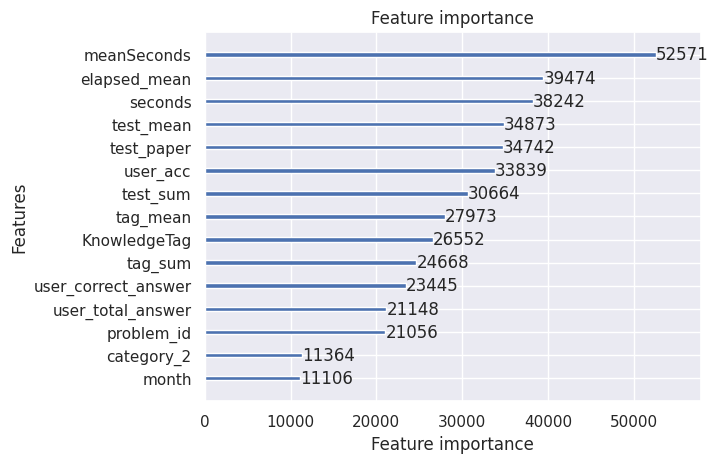

In [ ]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model)
_

## 5. Inference

In [ ]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path, dtype=dtype, parse_dates=['Timestamp'])

# FEATURE ENGINEERING
test_df.sort_values(['userID','Timestamp'], inplace=True)
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [ ]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [ ]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "LGBM2_submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/LGBM2_submission.csv


###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

